# MLP with the Adam optimizer in Tensorflow with Best Hyperparameters

In [3]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.math import argmax
from sklearn.metrics import classification_report
import wandb
from pprint import pprint
from matplotlib import pyplot as plt

from tf_utils import create_model, train_model
from plot_utils import plot_training, show_confusion_matrix

## Login to Wandb

In [4]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Load best hyperparameters

In [5]:
api = wandb.Api()
sweep = api.sweep("nsiete23/tf_mlp/sweeps/12a25071")

best_config = sweep.best_run().config
pprint(best_config)

wandb: Sorting runs by +summary_metrics.val_loss


{'batch_size': 128,
 'beta_1': 0.986435025614692,
 'beta_2': 0.9904482393527106,
 'dense_1': 485,
 'dense_2': 176,
 'dense_3': 131,
 'dense_4': 122,
 'epochs': 19,
 'learning_rate': 0.00012885226472854095}


## Load dataset and show examples

4422102/4422102 [==============================] - 0s 0us/step


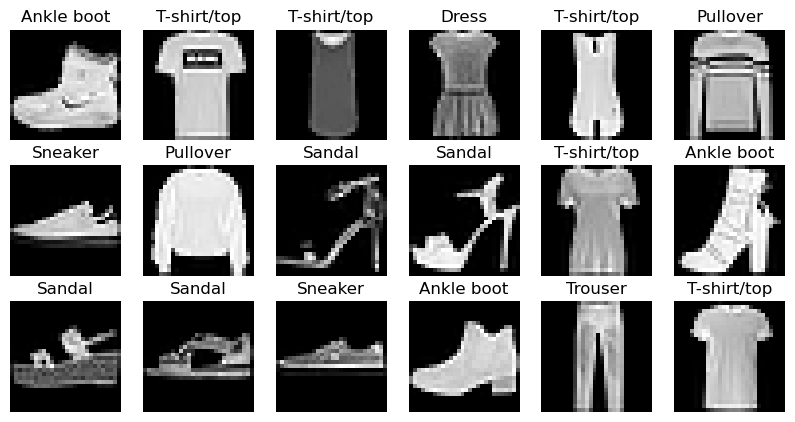

In [6]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

class_names = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

i = 0
plt.subplots(figsize=(10, 5))

for picture, label in zip(x_train[:18], y_train[:18]):
    subplot = plt.subplot(3, 6, i+1)
    subplot.set_title(class_names[label])
    plt.imshow(picture, cmap='gray')
    plt.axis('off')
    i = i + 1

plt.show()

## Start Wandb and train

In [7]:
wandb.init(config=best_config, project='tf_mlp', name='best-mlp-tf')

config = wandb.config

mlp = create_model(config)
mlp.summary()

mlp.compile(
    optimizer=Adam(learning_rate=config.learning_rate, beta_1=config.beta_1, beta_2=config.beta_2),
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()]
)

history = train_model(mlp, config, x_train, y_train)

wandb.finish()

wandb: Currently logged in as: v-modroczky (nsiete23). Use `wandb login --relogin` to force relogin


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 485)               380725    
                                                                 
 dense_1 (Dense)             (None, 176)               85536     
                                                                 
 dense_2 (Dense)             (None, 131)               23187     
                                                                 
 dense_3 (Dense)             (None, 122)               16104     
                                                                 
 dense_4 (Dense)             (None, 10)                1

epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇██████
val_loss,█▅▅▄▃▃▂▃▂▂▂▁▁▂▁▁▂▁▁
val_sparse_categorical_accuracy,▁▄▄▅▆▅▆▆▇▇▇▇▇▇▇█▇██
best_epoch,17
best_val_loss,0.30614
epoch,18
loss,0.21568
sparse_categorical_accuracy,0.92142
val_loss,0.30656


## Plot training and validation accuracy and loss

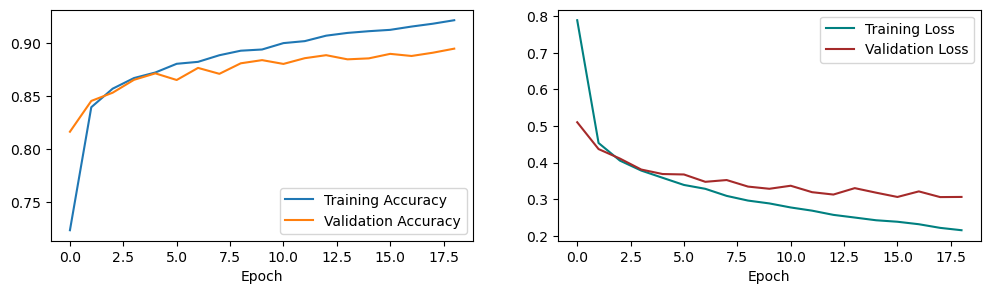

In [8]:
plot_training(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    history.history['loss'],
    history.history['val_loss']
)

## Run classification evaluation

In [9]:
y_pred = argmax(mlp.predict(x_test), axis = 1)
report = classification_report(y_test, y_pred, target_names=class_names, digits=4)
print(report)

313/313 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

 T-shirt/top     0.8238    0.8650    0.8439      1000
     Trouser     0.9908    0.9650    0.9777      1000
    Pullover     0.8641    0.7250    0.7885      1000
       Dress     0.8731    0.9010    0.8868      1000
        Coat     0.7738    0.8550    0.8124      1000
      Sandal     0.9717    0.9630    0.9674      1000
       Shirt     0.7136    0.7100    0.7118      1000
     Sneaker     0.9282    0.9690    0.9481      1000
         Bag     0.9729    0.9700    0.9715      1000
  Ankle boot     0.9702    0.9440    0.9569      1000

    accuracy                         0.8867     10000
   macro avg     0.8882    0.8867    0.8865     10000
weighted avg     0.8882    0.8867    0.8865     10000



## Visualize confusion matrix

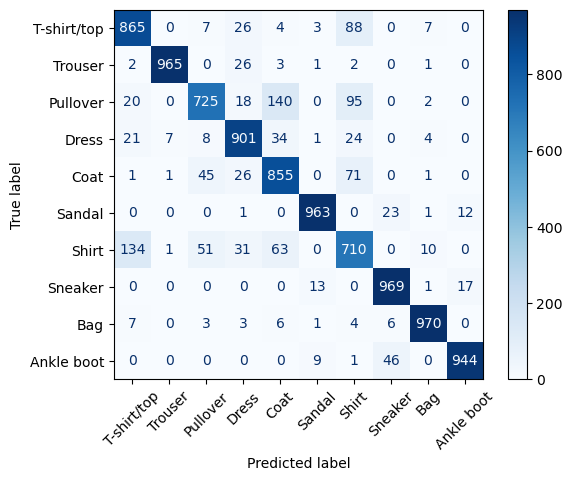

In [10]:
show_confusion_matrix(y_test, y_pred, class_names)